# How to do unsupervised learning with an autoencoder

By WJG. Took the code from https://blog.keras.io/building-autoencoders-in-keras.html

## 1. Create model 

* The autoencoder architecture is the following:
  Input --> 32FC layer --> Output
  FC means 'fully connected layer'.

* In the code, the layers are coded as follows:
  + First part (Input --> 32FC layer) is denoted as `encoder`;
  + Second part (32D layer --> Output) is denoted as `decoder`.
  + Concatenating the encoder and decoder yields the `autoencoder` model.

* The 32FC layer (i.e., output of the encoder) is treated as the encoded representation (aka feature vector).

* The decoder can be seen as a generative model taking as input 32D vectors. 

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')




Using TensorFlow backend.
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


## 2. Load MNIST data

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11476992/11490434 [============================>.] - ETA: 0s

## 3. Normalize images

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print x_train.shape
print x_test.shape

(60000, 784)
(10000, 784)


## 4. Train model

In [4]:
autoencoder.fit(x_train, x_train,
                nb_epoch=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s - loss: 0.3733 - val_loss: 0.2739
Epoch 2/50
60000/60000 [==============================] - 2s - loss: 0.2676 - val_loss: 0.2582
Epoch 3/50
60000/60000 [==============================] - 2s - loss: 0.2483 - val_loss: 0.2357
Epoch 4/50
60000/60000 [==============================] - 3s - loss: 0.2269 - val_loss: 0.2158
Epoch 5/50
60000/60000 [==============================] - 3s - loss: 0.2099 - val_loss: 0.2018
Epoch 6/50
60000/60000 [==============================] - 3s - loss: 0.1979 - val_loss: 0.1917
Epoch 7/50
60000/60000 [==============================] - 3s - loss: 0.1891 - val_loss: 0.1840
Epoch 8/50
60000/60000 [==============================] - 2s - loss: 0.1821 - val_loss: 0.1776
Epoch 9/50
60000/60000 [==============================] - 3s - loss: 0.1762 - val_loss: 0.1720
Epoch 10/50
60000/60000 [==============================] - 3s - loss: 0.1710 - val_loss: 0.1670

## 5. Encode and decode images from test set

First row in the resulting figure are the input images
Second row in the resulting figure are the reconstructed images.
The 32D codes are in `encoded_imgs`

In [5]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
## Here we can pass our own encodngs to the decoder to predict

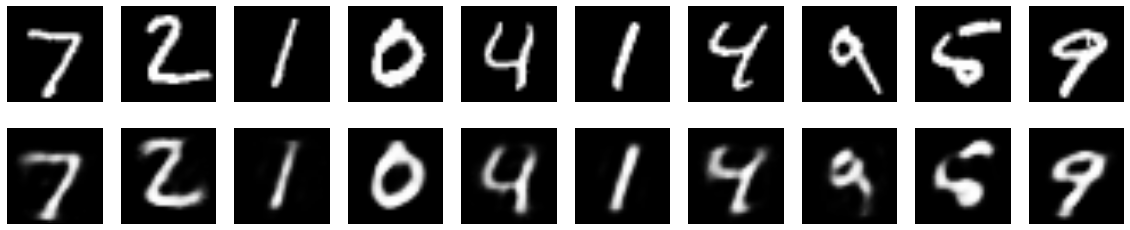

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = (10, 10)
#plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)

    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 6. Visualize encoded vectors

The encoder generates one 32D vector per image. We can visualize the collection of vectors with,e.g., PCA  (Note: Deeper architectures would
allow us to map directly the images to 2D vectors; https://blog.keras.io/building-autoencoders-in-keras.html). Below we visualize the vectors generated for the test dataset only (10k images). In the scatter plot, one data point corresponds to one image. The colors  are the actual digits annotations (which were NOT used during training). Even with this shallow
architecture we see that the digits are NOT randomly scattered, but rather the autoencoder managed to extract some structure within the data. The 32D vectors (or the PCA components, if you wish) can be used as feature vectors for, e.g., training other machine-learning methods. 

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
encoded_imgs = encoder.predict(x_test);
nImages = encoded_imgs.size / 32;
print nImages
data = encoded_imgs.reshape(nImages,32);
pca.fit(data);
scores = pca.transform(data);
plt.rcParams['image.cmap'] = 'jet'
plt.figure(figsize=(6, 6))
plt.scatter(scores[:, 0], scores[:, 1], c=y_test)
plt.colorbar()
plt.show()


10000


NameError: name 'plt' is not defined

## 7. Synthesize some images with the decoder

We'll take a reference encoding vector from the test set and add a noise vector from a zero-mean Gaussian with standard deviation `sigma`. By varying `sigma` we can add a stronger distortion to the encoding, which leads to some interesting synthetically generated patterns. We could also pass directly the noise vector to the decoder, which yields even weirder images.

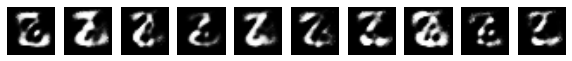

In [36]:
#sigma = 0.01;
#sigma = 0.1
#sigma = 1;
sigma = 3;
#sigma = 10;

n = 10  # how many digits we will display
plt.figure(figsize=(10, 2))
plt.rcParams['image.cmap'] = 'gray'
for i in range(n):  
    # synthesize digit from a real image distorted with a random vector
    ax = plt.subplot(2, n, i + 1)
    noise = sigma * np.random.randn(32) # 32 is the encoding dimension
    mu = encoded_imgs[1]; # some reference encoding, to not be so far away in the latent space
    z = mu + noise.reshape(-1,32); 
    digitSynth = decoder.predict(z);
    plt.imshow(digitSynth.reshape(28, 28))   
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

